In [2]:
#Librerie utili
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

In [3]:
con = sqlite3.connect("../code/omnet/simulations/results/simulate.sca")

# Confidence Interval Analysis

In [4]:
#THROUGHPUT

dfThroughput=pd.read_sql_query("""
select scenario, config, clients, attrValue, statCount / 3600.0 as throughput
from runConfig rc inner join statistic s on rc.runId = s.runId
        inner join runAttr ra on s.runId = ra.runId
where statName = "completedTransactions:stats"
 AND attrName = "repetition"
order by scenario, config, clients, attrValue
""", con)

#Getting all the configurations in the simulation table (column config)
#configurations=dfThroughput['config'].unique()
configurations=['c1','c3','c5','c8']

#Getting all the scenarios in the simulation table (column config)
scenarios=dfThroughput['scenario'].unique()

print(dfThroughput['throughput'].std())
print(dfThroughput['throughput'].mean())


#Test
print(configurations)

print(dfThroughput)


4.110107518032045
2.5357906597222413
['c1', 'c3', 'c5', 'c8']
     scenario config  clients attrValue  throughput
0          s1     c1        1         0    2.083333
1          s1     c1        1         1    2.012222
2          s1     c1        1         2    2.058056
3          s1     c1        1         3    2.076389
4          s1     c1        1         4    2.040833
...       ...    ...      ...       ...         ...
7995       s4     c8       49         5    0.628056
7996       s4     c8       49         6    0.593056
7997       s4     c8       49         7    0.620833
7998       s4     c8       49         8    0.587222
7999       s4     c8       49         9    0.589444

[8000 rows x 5 columns]


# Simulation Results

In [5]:
#THROUGHPUT

dfThroughput=pd.read_sql_query("""
SELECT clients, scenario, config, AVG(statCount) / 3600.0 as throughput 
FROM runConfig NATURAL JOIN statistic
WHERE statName = "completedTransactions:stats" 
GROUP BY scenario,config, clients, moduleName
ORDER BY clients
""", con)

#Getting all the configurations in the simulation table (column config)
#configurations=dfThroughput['config'].unique()
configurations=['c1','c3','c5','c8']

#Getting all the scenarios in the simulation table (column config)
scenarios=dfThroughput['scenario'].unique()


#Test
print(configurations)

print(dfThroughput)

print(dfThroughput['throughput'].max())

['c1', 'c3', 'c5', 'c8']
     clients scenario config  throughput
0          1       s1     c1    2.052250
1          1       s1     c2    0.455556
2          1       s1     c3    0.735722
3          1       s1     c4    0.735583
4          1       s1     c5    1.326833
..       ...      ...    ...         ...
795       49       s4     c4    0.592472
796       49       s4     c5    1.503389
797       49       s4     c6    0.254250
798       49       s4     c7    0.253389
799       49       s4     c8    0.613361

[800 rows x 4 columns]
24.04675


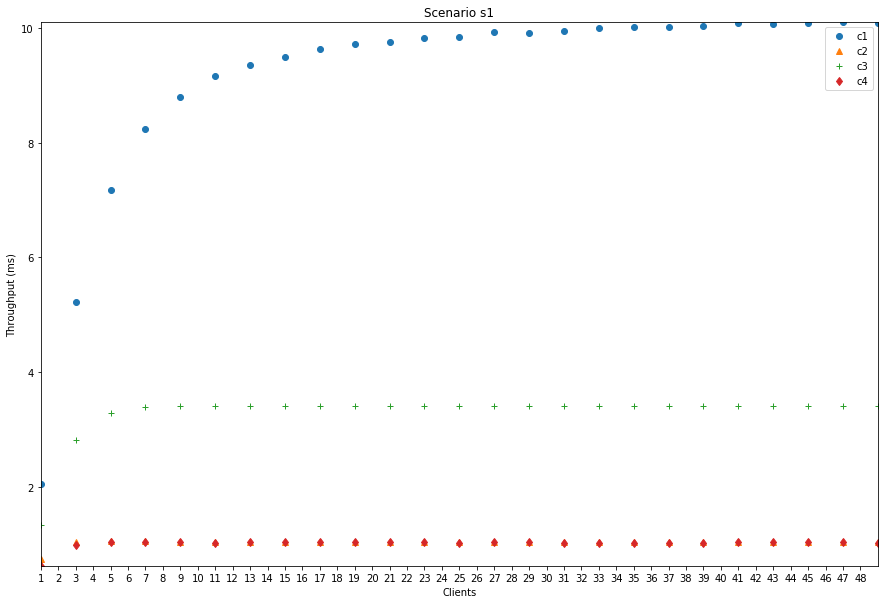

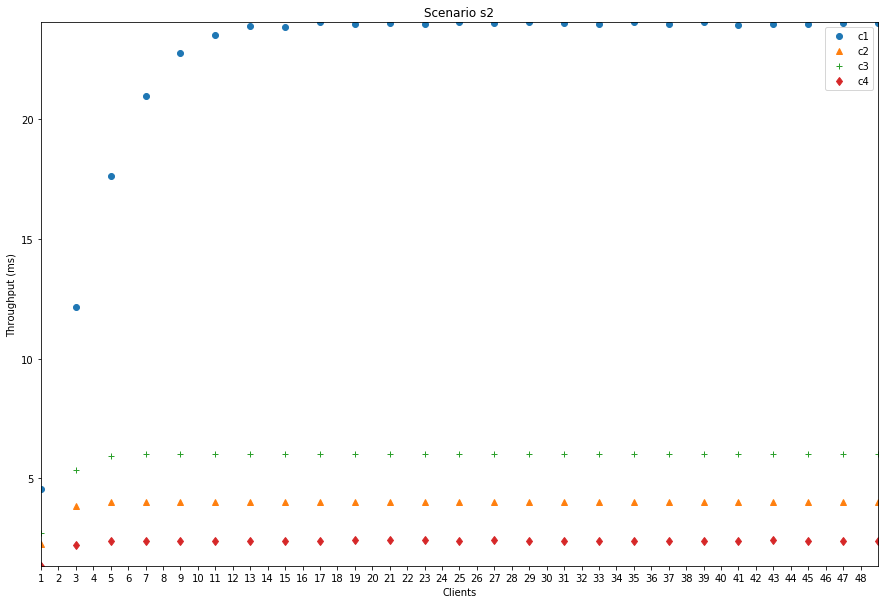

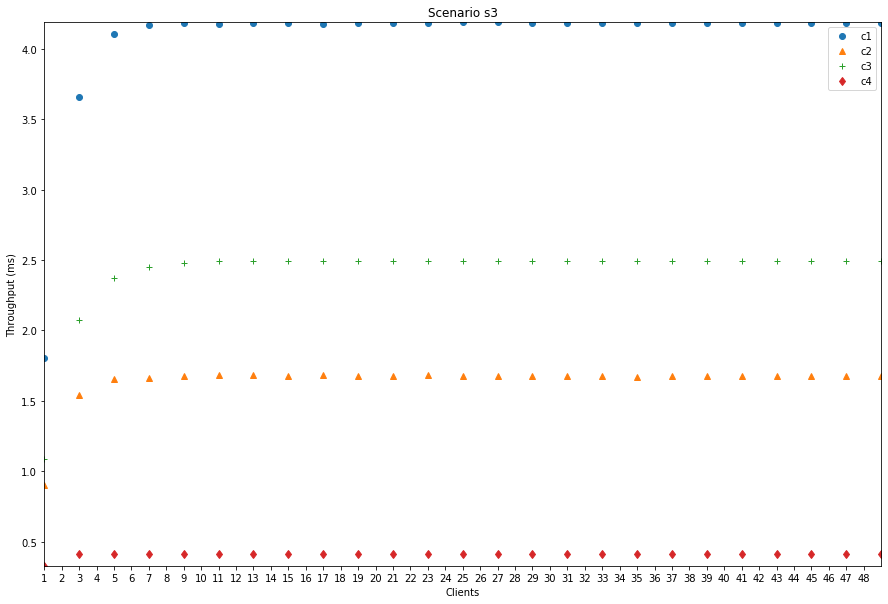

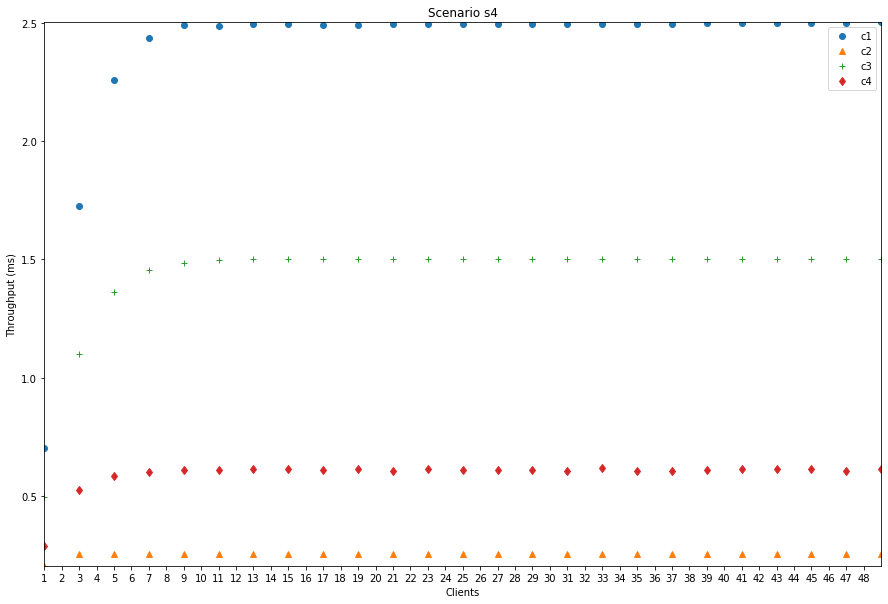

In [8]:
#FOR EVERY SCENARIO AND EVERY CONFIGURATIONS SHOW HOW CHANGE THE THROUGHPUT TIME WITH DIFFERENT NUMBER OF CLIENTS

for scenario in scenarios:
    plt.figure(figsize=(15,10))
    plt.title("Scenario "+scenario)
    plt.margins(0)
    plt.xticks(range(dfThroughput['clients'].min(),dfThroughput['clients'].max()))
    markers=["o","^","+","d","h",]
    for index,conf in enumerate(configurations):
        dfTemp=dfThroughput.loc[(dfThroughput['scenario']== scenario) & (dfThroughput['config'] == conf)]
        plt.plot(dfTemp['clients'], dfTemp['throughput'],markers[index%len(markers)],linestyle='None',)
        #Plot error bar
        
    #LABELLING THE PLOT
    plt.xlabel('Clients') 
    plt.ylabel('Throughput (ms)')
    #plt.legend(configurations)
    plt.legend(['c1','c2','c3','c4'])
    plt.show()



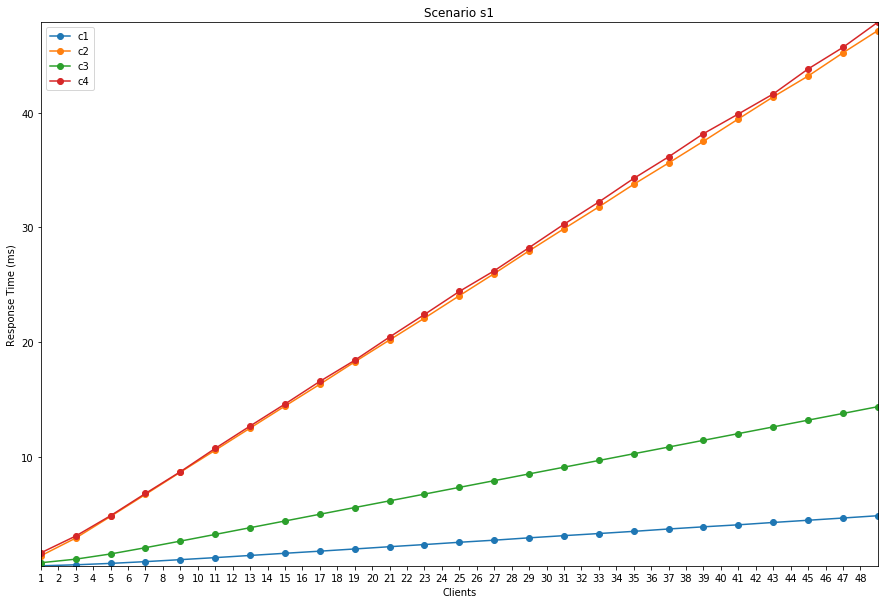

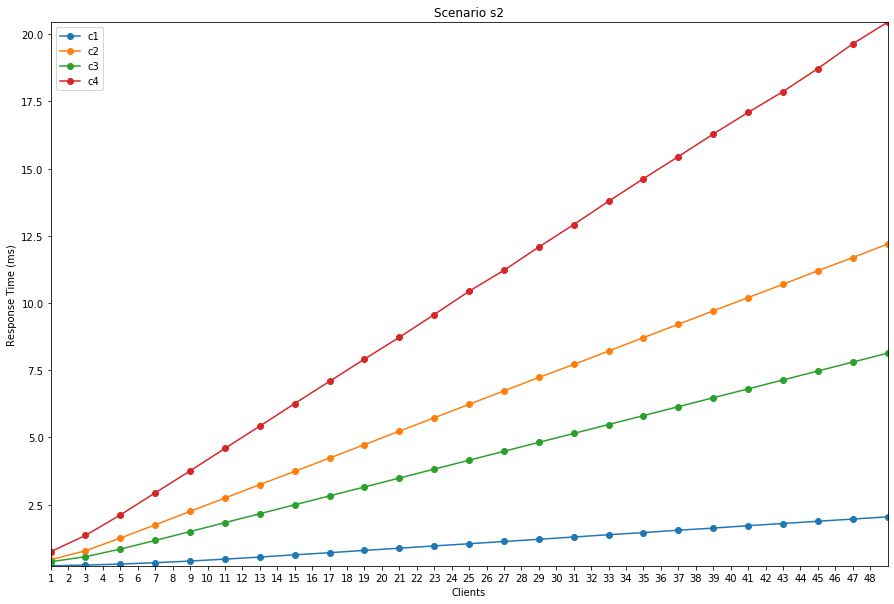

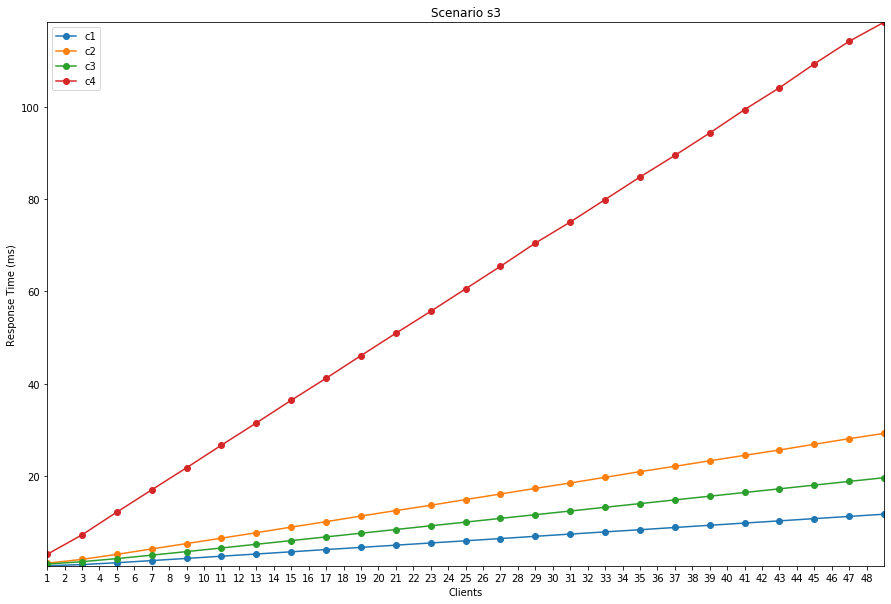

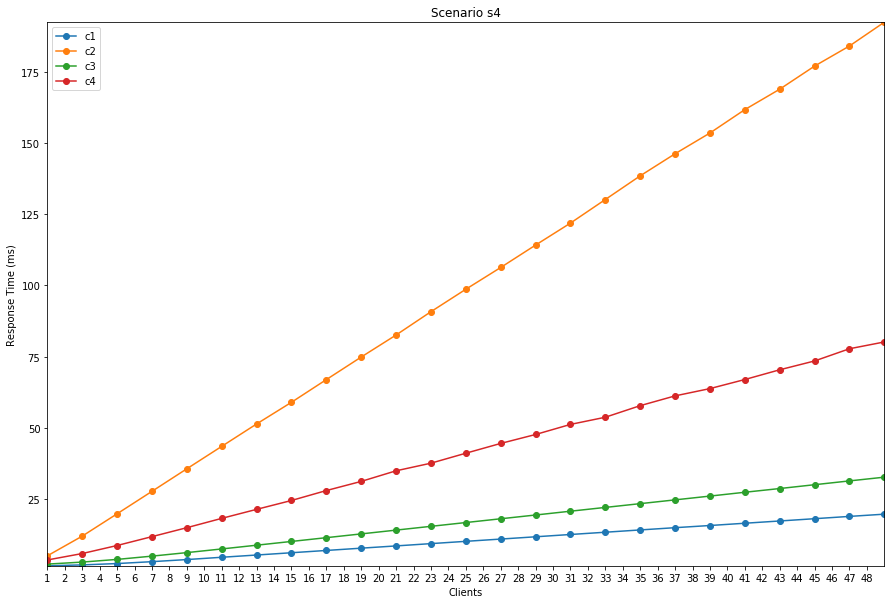

In [61]:
#RENSPONSE TIME

#QUERY DB
dfResponseTime=pd.read_sql_query("""
SELECT clients, scenario, config,AVG(statMean) as responseTime 
FROM runConfig NATURAL JOIN statistic
WHERE 
		statName = "responseTimeStat:stats" AND
		moduleName = "Network"
GROUP BY scenario,config, clients
ORDER BY clients
""", con)

#FOR EVERY SCENARIO AND EVERY CONFIGURATIONS SHOW HOW CHANGE THE RESPONSE TIME WITH DIFFERENT NUMBER OF CLIENTS
for scenario in scenarios:
    plt.figure(figsize=(15,10))
    plt.title("Scenario "+scenario)
    plt.margins(0)
    plt.xticks(range(dfResponseTime['clients'].min(),dfResponseTime['clients'].max()))
    for conf in configurations:
        dfTemp=dfResponseTime.loc[(dfResponseTime['scenario']== scenario) & (dfResponseTime['config'] == conf)]
        plt.plot(dfTemp['clients'], dfTemp['responseTime'],marker='o')
    
    #LABELLING THE PLOT
    
    plt.xlabel('Clients') 
    plt.ylabel('Response Time (ms)')
    #plt.legend(configurations)
    plt.legend(['c1','c2','c3','c4'])
    plt.show()





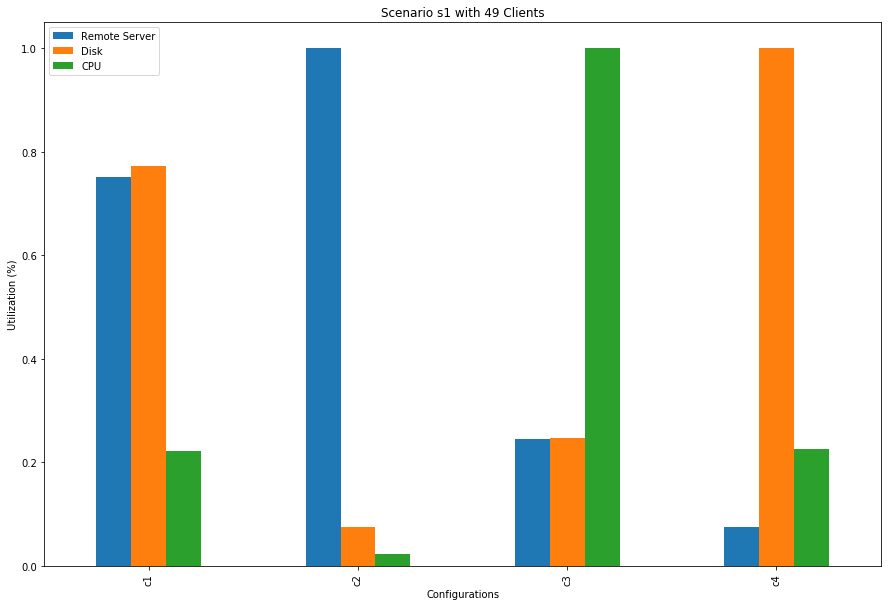

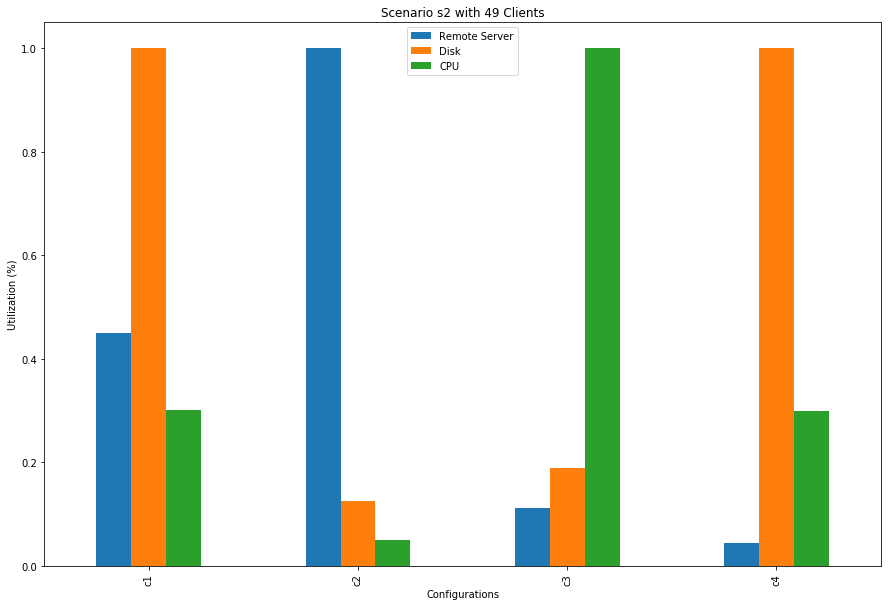

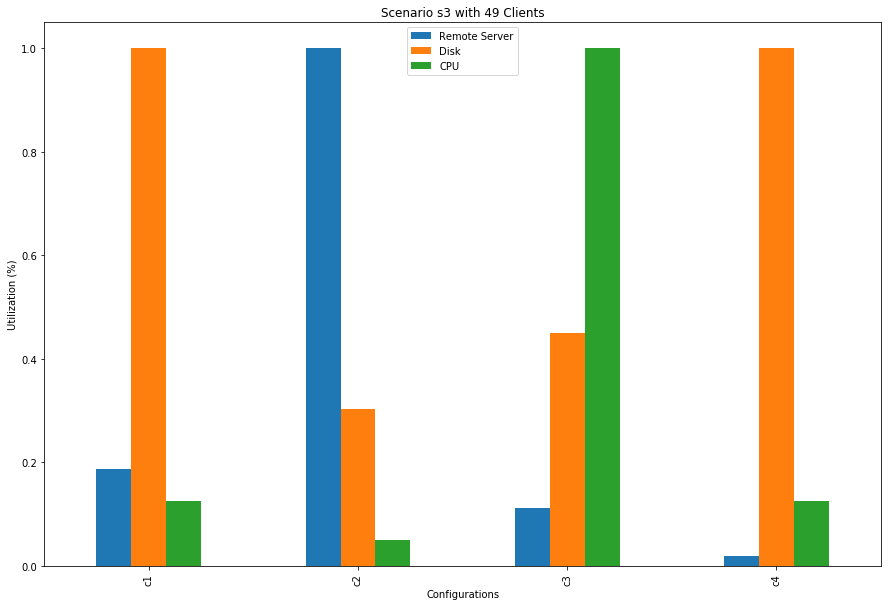

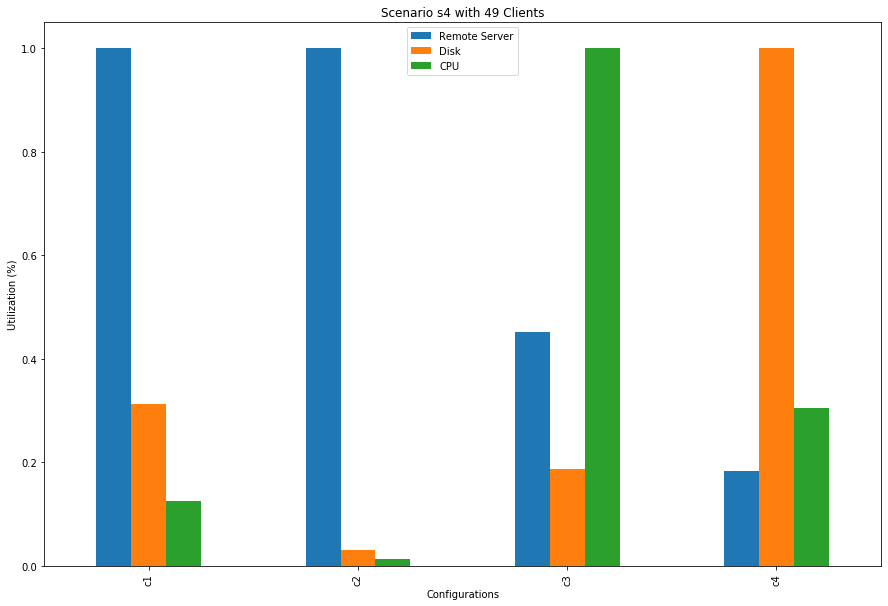

In [87]:
#COMPONENTS UTILIZATION GROUPED BY SCENARIOS WITH FINAL CONFIGURATIONS

#QUERY DB
dfUtilization=pd.read_sql_query("""
SELECT clients, scenario, config, moduleName, AVG(statSum)/4800 as utilization 
FROM runConfig NATURAL JOIN statistic
WHERE
		statName = "workingStat:stats"
GROUP BY scenario,config, clients, moduleName
ORDER BY clients
""", con)


#Prendo solo le configurazioni rilevanti

dfUtilization=dfUtilization.loc[(dfUtilization.config=="c1") | (dfUtilization.config=="c3")|(dfUtilization.config=="c5")|(dfUtilization.config=="c8")]

#Rimappo i nomi nel dataframe con un dizionario
configDictionary={"c1": "c1","c3": "c2","c5": "c3","c8": "c4"}
dfUtilization["config"]=dfUtilization["config"].map(configDictionary)

#Set here number of clients 
clientsNum=49

#For every configurations plot a graph of utilization of the components by every scenario

for scenario in scenarios:

    dfTemp=dfUtilization.loc[(dfUtilization['clients']== clientsNum)&(dfUtilization['scenario']== scenario)]

    plot=dfTemp.groupby(['config', 'moduleName'])['utilization'].mean().unstack().plot.bar(figsize=(15,10))
    plt.title('Scenario '+scenario+' with '+str(clientsNum)+' Clients')
    
    #LABELLING THE PLOT

    plt.xlabel('Configurations') 
    plt.ylabel('Utilization (%)')
    plt.legend(['Remote Server',"Disk","CPU"])
    plt.show()

In [7]:
con.close()